In [41]:
import pandas as pd
import numpy as np
from preprocess import Preprocessing as prep
from sklearn.model_selection import train_test_split

In [42]:
data = pd.read_csv('datasets/cefr_leveled_texts.csv')
data2 = pd.read_csv('datasets/cefr_leveled_texts_2.csv')
data.head()

,text,label
0,Hi!\nI've been meaning to write for ages and f...,B2
1,﻿It was not so much how hard people found the ...,B2
2,Keith recently came back from a trip to Chicag...,B2
3,"The Griffith Observatory is a planetarium, and...",B2
4,-LRB- The Hollywood Reporter -RRB- It's offici...,B2


In [44]:
len(data)

1494

In [45]:
data2.head()

,text,label
0,It is not made of silicon; and it is not a riv...,B1
1,"Besides these big sports, America of course ha...",B1
2,"After Calliope, the Muse of epic poetry, gave ...",B1
3,Madame Thibault's Hall of Waxworks attracted a...,B1
4,Jane Addams: A Woman of Character\nWhen you th...,B1


In [47]:
data = pd.concat([data,data2])
len(data)

2994

In [53]:
data['label_encoded'] = data['label'].apply(lambda x: prep.encode_label(x))

In [54]:
data['label_encoded'].groupby(data['label']).count()

label
A1    368
A2    580
B1    637
B2    634
C1    435
C2    340
Name: label_encoded, dtype: int64

In [55]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

In [56]:
train_df['label_encoded'].groupby(train_df['label']).count()

label
A1    298
A2    453
B1    511
B2    493
C1    358
C2    282
Name: label_encoded, dtype: int64

In [26]:
from transformers import BertTokenizer
PRETRAINED_LM = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_LM, do_lower_case=True)
tokenizer

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [27]:
def encode(docs):
    '''
    This function takes list of texts and returns input_ids and attention_mask of texts
    '''
    encoded_dict = tokenizer.batch_encode_plus(docs, add_special_tokens=True, max_length=128, padding='max_length',
                            return_attention_mask=True, truncation=True, return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks

In [28]:
train_input_ids, train_att_masks = encode(train_df['text'].values.tolist())
test_input_ids, test_att_masks = encode(test_df['text'].values.tolist())

In [29]:
import torch
train_y = torch.LongTensor(train_df['label_encoded'].values.tolist())
test_y = torch.LongTensor(test_df['label_encoded'].values.tolist())
train_y.size(), test_y.size()

(torch.Size([1795]), torch.Size([449]))

In [30]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

BATCH_SIZE = 8

train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_input_ids, test_att_masks, test_y)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

In [31]:
from transformers import BertForSequenceClassification
N_labels = len(train_df.label_encoded.unique())
model = BertForSequenceClassification.from_pretrained(PRETRAINED_LM,
                                                       num_labels=N_labels,
                                                       output_attentions=False,
                                                       output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.cpu()


In [33]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

EPOCHS = 30
LEARNING_RATE = 2e-6

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer, 
             num_warmup_steps=0,
            num_training_steps=len(train_dataloader)*EPOCHS )

In [34]:
from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm
import numpy as np
import math

train_loss_per_epoch = []
val_loss_per_epoch = []


for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)
        
        loss = output.loss
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))              


    '''
    Validation
    '''
    model.eval()
    test_loss = 0
    test_pred = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(test_dataloader,desc='Test')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            test_loss += loss.item()
   
            test_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
        
    val_loss_per_epoch.append(test_loss / (step_num_e + 1))
    test_pred = np.concatenate(test_pred)

    '''
    Loss message
    '''
    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(train_df) / BATCH_SIZE), train_loss / (step_num + 1)))
    print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(test_df) / BATCH_SIZE), test_loss / (step_num_e + 1)))

Epoch:  1


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]

225/225 train loss: 1.7577443896399605 
57/57 val loss: 1.596151964706287 
Epoch:  2


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]

225/225 train loss: 1.516314720577664 
57/57 val loss: 1.3989823167784172 
Epoch:  3


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]

225/225 train loss: 1.367080898284912 
57/57 val loss: 1.2828358317676343 
Epoch:  4


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]

225/225 train loss: 1.2629279216130576 
57/57 val loss: 1.1991138855616252 
Epoch:  5


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]

225/225 train loss: 1.1835325235790677 
57/57 val loss: 1.1421505348724232 
Epoch:  6


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]

225/225 train loss: 1.1179956367280748 
57/57 val loss: 1.1098883371604116 
Epoch:  7


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]

225/225 train loss: 1.0594471573829651 
57/57 val loss: 1.074731234918561 
Epoch:  8


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]

225/225 train loss: 1.0019088758362664 
57/57 val loss: 1.0591095900326444 
Epoch:  9


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]

225/225 train loss: 0.9647889015409682 
57/57 val loss: 1.0459893371975213 
Epoch:  10


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]

225/225 train loss: 0.9192046901914809 
57/57 val loss: 1.048804394508663 
Epoch:  11


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]

225/225 train loss: 0.8723824675877889 
57/57 val loss: 1.0193513297198111 
Epoch:  12


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]

225/225 train loss: 0.8409346616268158 
57/57 val loss: 1.0215023546888118 
Epoch:  13


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]

225/225 train loss: 0.7943180632591248 
57/57 val loss: 1.0123322794311924 
Epoch:  14


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]

225/225 train loss: 0.7732371728950077 
57/57 val loss: 1.0032663957068795 
Epoch:  15


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]

225/225 train loss: 0.7305085901419321 
57/57 val loss: 1.0258157587887948 
Epoch:  16


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]

225/225 train loss: 0.6940791202916039 
57/57 val loss: 1.0010548581679661 
Epoch:  17


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]

225/225 train loss: 0.6829560837480757 
57/57 val loss: 0.9999873266931165 
Epoch:  18


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]

225/225 train loss: 0.6557091875871023 
57/57 val loss: 1.0007788444820203 
Epoch:  19


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]

225/225 train loss: 0.6263034322526719 
57/57 val loss: 1.0091324547926586 
Epoch:  20


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]

225/225 train loss: 0.609107007847892 
57/57 val loss: 1.0057284413722523 
Epoch:  21


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]

225/225 train loss: 0.5824337425496843 
57/57 val loss: 1.0045113022390164 
Epoch:  22


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]

225/225 train loss: 0.5644152110152775 
57/57 val loss: 1.012202006421591 
Epoch:  23


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]

225/225 train loss: 0.5529366941584481 
57/57 val loss: 1.010420017859392 
Epoch:  24


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]

225/225 train loss: 0.5383489967717064 
57/57 val loss: 1.019076866800325 
Epoch:  25


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]

225/225 train loss: 0.5255480749077267 
57/57 val loss: 1.0100710005090947 
Epoch:  26


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]

225/225 train loss: 0.5179797473880979 
57/57 val loss: 1.0130437753702466 
Epoch:  27


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]

225/225 train loss: 0.5102403299013774 
57/57 val loss: 1.0092564368979973 
Epoch:  28


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]

225/225 train loss: 0.5044939059681363 
57/57 val loss: 1.016096230269524 
Epoch:  29


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]

225/225 train loss: 0.5014081186056137 
57/57 val loss: 1.0132127049983592 
Epoch:  30


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Test:   0%|          | 0/57 [00:00<?, ?it/s]

225/225 train loss: 0.49749571323394776 
57/57 val loss: 1.0149767119110675 


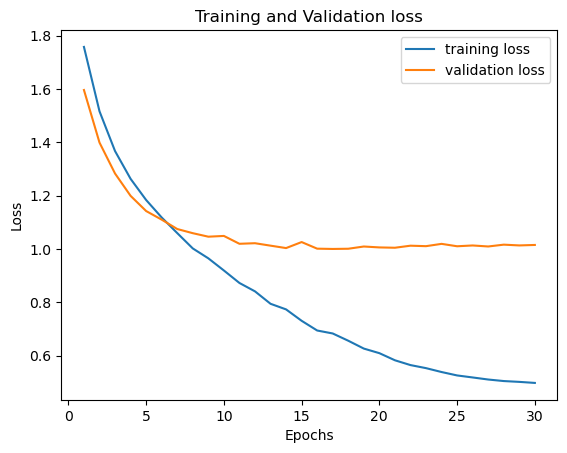

In [39]:
from matplotlib import pyplot as plt
epochs = range(1, EPOCHS +1 )
fig, ax = plt.subplots()
ax.plot(epochs,train_loss_per_epoch,label ='training loss')
ax.plot(epochs, val_loss_per_epoch, label = 'validation loss' )
ax.set_title('Training and Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

In [38]:
from sklearn.metrics import classification_report
label_names = ['A1','A2','B1','B2','C1','C2']
print('classifiation report')
print(classification_report(test_pred, test_df['label_encoded'].to_numpy(), target_names=label_names))

classifiation report
              precision    recall  f1-score   support

          A1       0.84      0.73      0.78        73
          A2       0.65      0.67      0.66       102
          B1       0.51      0.47      0.49        85
          B2       0.38      0.42      0.40        85
          C1       0.46      0.40      0.43        70
          C2       0.56      0.79      0.66        34

    accuracy                           0.56       449
   macro avg       0.57      0.58      0.57       449
weighted avg       0.57      0.56      0.56       449

